In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display,clear_output,HTML
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", DeprecationWarning)

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential

import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel,f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics

from xgboost import XGBClassifier


from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score,matthews_corrcoef

from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats
import re

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

Using TensorFlow backend.
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
    m['Features']=m['Features'].str.replace("dom_function_","")
    m['Features']=m['Features'].str.replace("js_function_","")
    m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
    m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [3]:
def model_build(model,X_train,Y_train,X_test,Y_test,tree=False,feat=None):
    
    y_pred_train=model.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    
    print("Accuracy of the model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=model.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the model for test data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    mcc=matthews_corrcoef(Y_test,y_pred_test)
    
    precision=precision_score(Y_test,y_pred_test)
    recall=recall_score(Y_test,y_pred_test)
    if tree==True:
        feat_impt_plot(model.feature_importances_,feat)
        return model,cm_train,cm_test,acc_train,acc_test,roc_auc,model.feature_importances_,mcc,precision,recall
    
    return model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc,precision,recall

def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    return model_build(knn,X_train,Y_train,X_test,Y_test)

# def Logistic_model(X_train,Y_train,X_test,Y_test):
#     print('\033[1m' + 'Logistic Regression' + '\033[0m')
#     log=LogisticRegression()
#     log.fit(X_train,Y_train)
    
#     return model_build(log,X_train,Y_train,X_test,Y_test)

def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier(random_state=0)
    rf.fit(X_train,Y_train)

    
    return model_build(rf,X_train,Y_train,X_test,Y_test,True,feat)

def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier(random_state=0)
    ada.fit(X_train,Y_train)
    
    return model_build(ada,X_train,Y_train,X_test,Y_test,True,feat)

def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier(random_state=0)
    gbc.fit(X_train,Y_train)
    
    return model_build(gbc,X_train,Y_train,X_test,Y_test,True,feat)

def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier(random_state=0)
    ext_tree.fit(X_train,Y_train)
    
    return model_build(ext_tree,X_train,Y_train,X_test,Y_test,True,feat)

def XGB(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'XGB Classifier' + '\033[0m')
    xgb=XGBClassifier(random_state=0)
    xgb.fit(X_train,Y_train)
    
    return model_build(xgb,X_train,Y_train,X_test,Y_test,True,feat)

def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier(random_state=0)
    bagging.fit(X_train,Y_train)
    
    return model_build(bagging,X_train,Y_train,X_test,Y_test)

def XGB(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'XGB Classifier' + '\033[0m')
    xgb=XGBClassifier(random_state=0)
    xgb.fit(X_train,Y_train)
    
    return model_build(xgb,X_train,Y_train,X_test,Y_test,True,feat)

def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    mcc=matthews_corrcoef(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    precision=precision_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    recall=recall_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc,precision,recall

In [4]:
### Read HTML 
df_html=pd.read_csv('../html/HTML.csv',index_col='domain')
df_html.drop(['Unnamed: 0'],axis=1,inplace=True)
cookie=[col for col in df_html.columns if 'number' in col]
df_html.drop(cookie,axis=1,inplace=True)
print("Shape of HTML dataset:",df_html.shape)
df_html.Target=df_html.Target.apply(lambda x: 1 if x=='Malicious' else 0)


### Read JS 
df_js=pd.read_csv('Javascript.csv',low_memory=False,index_col='domain')
cookie=[col for col in df_js.columns if 'number' in col]
df_js.drop(cookie,axis=1,inplace=True)
df_js.rename(columns={'Malicious':'Target'},inplace=True)
print("Shape of JS,DOM dataset:",df_js.shape)
df_js.Target=df_js.Target.apply(lambda x: 1 if x=='Malicious' else 0)


### Read HTTP
df_http=pd.read_csv('HTTP.csv')
df_http.rename(columns={'Malicious':'Target'},inplace=True)
df_http.fillna(value=0,inplace=True)
cookies=[columns for columns in df_http.columns if 'number' in columns]
df_http.drop(cookies,axis=1,inplace=True)
df_http=df_http[df_http['domain']!=0]
df_http.sort_values(by='Target',inplace=True,ascending=False)
df_http.drop_duplicates(['domain'], keep='first',inplace=True)
df_http=df_http.sample(frac=1,random_state=0)
df_http.set_index(['domain'],drop=True,inplace=True)
print("Shape of HTTP dataset:",df_http.shape)



### Read URL
df_url=pd.read_csv('URL.csv')
df_url.fillna(value=0,inplace=True)
cookies=[columns for columns in df_url.columns if 'number' in columns]
df_url.drop(cookies,axis=1,inplace=True)
df_url.drop(['url_host','url_ip'],axis=1,inplace=True)
df_url=df_url[df_url['domain']!=0]
df_url.sort_values(by='Target',inplace=True,ascending=False)
df_url.drop_duplicates(['domain'], keep='first',inplace=True)
df_url=df_url.sample(frac=1,random_state=0)
print("Shape of URL dataset:",df_url.shape)
df_url.set_index('domain',inplace=True,drop=True)

Shape of HTML dataset: (43491, 1461)
Shape of JS,DOM dataset: (43294, 401)
Shape of HTTP dataset: (45856, 672)
Shape of URL dataset: (46771, 4194)


In [5]:
df=pd.concat([df_js,df_html,df_http,df_url],axis=1,join='inner')
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df['Target_z']=df[['Target','Target','Target','Target']].apply(max,axis=1)
df.drop(['Target','Target','Target','Target'],axis=1,inplace=True)
print("Shape of combined dataset:",df.shape)
df.rename(columns={'Target_z':'Target'},inplace=True)
df.Target.value_counts()

Shape of combined dataset: (39183, 6723)


0    34742
1     4441
Name: Target, dtype: int64

In [6]:
columns=['js_function_.push(','a_count','a_href_http','a_href_https','a_href_out_of_domain','a_href_relative',
 'center_count','iframe_src_.html','img_src_http','input_count','li_count','link_href_out_of_domain','link_type_text/css',
 'meta_count','p_count','script_count','script_src_https','script_src_out_of_domain','title_count',
 'http_header_cache-control_set_max-age','http_header_content-encoding_gzip','http_header_content-length',
 'http_header_server_apache','http_header_transfer-encoding_chunked','http_header_vary_user-agent','http_header_via_1.1',
 'url_char_.','url_char_d','url_char_f','url_char_i','url_char_l','url_char_p','url_char_t','url_char_w',
 'url_char_y','url_char_z','url_extension_endswith_.com','url_extensions','url_length','Target']

In [7]:
print("features being used")
display(columns)

features being used


['js_function_.push(',
 'a_count',
 'a_href_http',
 'a_href_https',
 'a_href_out_of_domain',
 'a_href_relative',
 'center_count',
 'iframe_src_.html',
 'img_src_http',
 'input_count',
 'li_count',
 'link_href_out_of_domain',
 'link_type_text/css',
 'meta_count',
 'p_count',
 'script_count',
 'script_src_https',
 'script_src_out_of_domain',
 'title_count',
 'http_header_cache-control_set_max-age',
 'http_header_content-encoding_gzip',
 'http_header_content-length',
 'http_header_server_apache',
 'http_header_transfer-encoding_chunked',
 'http_header_vary_user-agent',
 'http_header_via_1.1',
 'url_char_.',
 'url_char_d',
 'url_char_f',
 'url_char_i',
 'url_char_l',
 'url_char_p',
 'url_char_t',
 'url_char_w',
 'url_char_y',
 'url_char_z',
 'url_extension_endswith_.com',
 'url_extensions',
 'url_length',
 'Target']

In [8]:
df['url_extension_endswith_.com']=df['url_extension_endswith_.com'].apply(lambda x: 1 if x==True else x)
df['url_extension_endswith_.com']=df['url_extension_endswith_.com'].astype(int)

### <a id='1' style="text-decoration : none; color : #000000;"> 1. Initial Models</a>

In [9]:
df_sel=df[columns].copy(deep=True)

In [10]:
train=df_sel.iloc[:31346,:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=df_sel.iloc[31346:,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)
columns.remove('Target')

In [11]:
ind_columns=['KNeighborsClassifier','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','XGB','BaggingClassifier','Neural Network-1']

f=[KNN_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,XGB,Bagging,DeepLearning1]

## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC','Precision','Recall'])

feat_imp=[None]*5
j=0
for i in range(0,8):
    if i>=1 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc,prec,rec=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc,prec,rec=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc,prec,rec])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9806035857844702
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27624   181    27805
True         427  3114     3541
__all__    28051  3295    31346

Accuracy of the model for test data is: 0.9744800306239633
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6869    68     6937
True         132   768      900
__all__     7001   836     7837



RandomForest Classifier
Accuracy of the model for training data is: 0.9974159382377337
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27796     9    27805
True          72  3469     3541
__all__    27868  3478    31346

Accuracy of the model for test data is: 0.9797116243460507
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6897    40     6937
True         119   781      900
__all__     7016   821     7837



Adaoost Classifier
Accuracy of the model for training data is: 0.9737446564154916
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27466   339    27805
True         484  3057     3541
__all__    27950  3396    31346

Accuracy of the model for test data is: 0.9691208370549955
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6841    96     6937
True         146   754      900
__all__     6987   850     7837



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9794232118930645
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27624   181    27805
True         464  3077     3541
__all__    28088  3258    31346

Accuracy of the model for test data is: 0.9747352303177236
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6878    59     6937
True         139   761      900
__all__     7017   820     7837



ExtraTree Classifier
Accuracy of the model for training data is: 0.9993938620557646
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27803     2    27805
True          17  3524     3541
__all__    27820  3526    31346

Accuracy of the model for test data is: 0.9776700267959678
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6890    47     6937
True         128   772      900
__all__     7018   819     7837



XGB Classifier
Accuracy of the model for training data is: 0.9794870158871946
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27631   174    27805
True         469  3072     3541
__all__    28100  3246    31346

Accuracy of the model for test data is: 0.9761388286334056
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6886    51     6937
True         136   764      900
__all__     7022   815     7837



Bagging Classifier
Accuracy of the model for training data is: 0.9973521342436037
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27792    13    27805
True          70  3471     3541
__all__    27862  3484    31346

Accuracy of the model for test data is: 0.9776700267959678
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6883    54     6937
True         121   779      900
__all__     7004   833     7837



Neural Network-1
The accuracy of the model on training data is: 0.9948637784725324


Predicted  False  True  __all__
Actual                         
False      27777    28    27805
True         133  3408     3541
__all__    27910  3436    31346

The accuracy of the model on test data is: 0.9740972310833227


Predicted  False  True  __all__
Actual                         
False       6861    76     6937
True         127   773      900
__all__     6988   849     7837

### <a id='1.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [12]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[0].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'KNN_model')


trace2 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[1].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[2].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[3].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[4].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')


trace1 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[5].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'XGB')


trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[6].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[7].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [13]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.980604,3114.0,27624.0,181.0,427.0,0.006510,0.120587
RandomForestClassifier,0.997416,3469.0,27796.0,9.0,72.0,0.000324,0.020333
AdaBoostClassifier,0.973745,3057.0,27466.0,339.0,484.0,0.012192,0.136685
GradientBoostingClassifier,0.979423,3077.0,27624.0,181.0,464.0,0.006510,0.131036
ExtraTreeClassifier,0.999394,3524.0,27803.0,2.0,17.0,0.000072,0.004801
XGB,0.979487,3072.0,27631.0,174.0,469.0,0.006258,0.132448
BaggingClassifier,0.997352,3471.0,27792.0,13.0,70.0,0.000468,0.019768
Neural Network-1,0.994864,3408.0,27777.0,28.0,133.0,0.001007,0.037560


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC,Precision,Recall
index,,,,,,,,,,,
KNeighborsClassifier,0.974480,768.0,6869.0,68.0,132.0,0.009803,0.146667,0.921765,0.871214,0.918660,0.853333
RandomForestClassifier,0.979712,781.0,6897.0,40.0,119.0,0.005766,0.132222,0.931006,0.897437,0.951279,0.867778
AdaBoostClassifier,0.969121,754.0,6841.0,96.0,146.0,0.013839,0.162222,0.911969,0.844787,0.887059,0.837778
GradientBoostingClassifier,0.974735,761.0,6878.0,59.0,139.0,0.008505,0.154444,0.918525,0.871919,0.928049,0.845556
ExtraTreeClassifier,0.977670,772.0,6890.0,47.0,128.0,0.006775,0.142222,0.925501,0.886930,0.942613,0.857778
XGB,0.976139,764.0,6886.0,51.0,136.0,0.007352,0.151111,0.920769,0.878964,0.937423,0.848889
BaggingClassifier,0.977670,779.0,6883.0,54.0,121.0,0.007784,0.134444,0.928886,0.887326,0.935174,0.865556
Neural Network-1,0.974097,773.0,6861.0,76.0,127.0,0.010956,0.141111,0.928886,0.869838,0.910483,0.858889


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [14]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 2. OverSampling </a>

In [17]:
sm = SMOTE(random_state=12, ratio = {1:27805})
X_train, Y_train = sm.fit_sample(scaled_X_train,train_Y)


ind_columns=['KNeighborsClassifier','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','XGB','BaggingClassifier','Neural Network-1']

f=[KNN_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,XGB,Bagging,DeepLearning1]

## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC','Precision','Recall'])

feat_imp=[None]*5
j=0
for i in range(0,8):
    if i>=1 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc,prec,rec=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc,prec,rec=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc,prec,rec])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9807408739435354
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26785   1020    27805
True          51  27754    27805
__all__    26836  28774    55610

Accuracy of the model for test data is: 0.9448768661477607
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6590   347     6937
True          85   815      900
__all__     6675  1162     7837



RandomForest Classifier
Accuracy of the model for training data is: 0.9990109692501349
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      27792     13    27805
True          42  27763    27805
__all__    27834  27776    55610

Accuracy of the model for test data is: 0.9788184254178895
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6882    55     6937
True         111   789      900
__all__     6993   844     7837



Adaoost Classifier
Accuracy of the model for training data is: 0.9638374393094767
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26757   1048    27805
True         963  26842    27805
__all__    27720  27890    55610

Accuracy of the model for test data is: 0.9561056526732168
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6676   261     6937
True          83   817      900
__all__     6759  1078     7837



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9758676497032908
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      27135    670    27805
True         672  27133    27805
__all__    27807  27803    55610

Accuracy of the model for test data is: 0.9661860405767513
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6764   173     6937
True          92   808      900
__all__     6856   981     7837



ExtraTree Classifier
Accuracy of the model for training data is: 0.9996583348318647
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      27803      2    27805
True          17  27788    27805
__all__    27820  27790    55610

Accuracy of the model for test data is: 0.9786908255710093
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6887    50     6937
True         117   783      900
__all__     7004   833     7837



XGB Classifier
Accuracy of the model for training data is: 0.974375112389858
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      27098    707    27805
True         718  27087    27805
__all__    27816  27794    55610

Accuracy of the model for test data is: 0.9643996427204288
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6751   186     6937
True          93   807      900
__all__     6844   993     7837



Bagging Classifier
Accuracy of the model for training data is: 0.9985254450638374
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      27785     20    27805
True          62  27743    27805
__all__    27847  27763    55610

Accuracy of the model for test data is: 0.9765216281740462
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6870    67     6937
True         117   783      900
__all__     6987   850     7837



Neural Network-1
The accuracy of the model on training data is: 0.9970508901276749


Predicted  False   True  __all__
Actual                          
False      27711     94    27805
True          70  27735    27805
__all__    27781  27829    55610

The accuracy of the model on test data is: 0.9716728339925992


Predicted  False  True  __all__
Actual                         
False       6831   106     6937
True         116   784      900
__all__     6947   890     7837

### <a id='2.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [18]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[0].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'KNN_model')


trace2 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[1].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[2].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[3].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[4].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')


trace1 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[5].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'XGB')


trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[6].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[7].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [19]:
### 14164
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.980741,27754.0,26785.0,1020.0,51.0,0.036684,0.001834
RandomForestClassifier,0.999011,27763.0,27792.0,13.0,42.0,0.000468,0.001511
AdaBoostClassifier,0.963837,26842.0,26757.0,1048.0,963.0,0.037691,0.034634
GradientBoostingClassifier,0.975868,27133.0,27135.0,670.0,672.0,0.024096,0.024168
ExtraTreeClassifier,0.999658,27788.0,27803.0,2.0,17.0,0.000072,0.000611
XGB,0.974375,27087.0,27098.0,707.0,718.0,0.025427,0.025823
BaggingClassifier,0.998525,27743.0,27785.0,20.0,62.0,0.000719,0.002230
Neural Network-1,0.997051,27735.0,27711.0,94.0,70.0,0.003381,0.002518


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC,Precision,Recall
index,,,,,,,,,,,
KNeighborsClassifier,0.944877,815.0,6590.0,347.0,85.0,0.050022,0.094444,0.927767,0.767566,0.701377,0.905556
RandomForestClassifier,0.978818,789.0,6882.0,55.0,111.0,0.007928,0.123333,0.934369,0.893497,0.934834,0.876667
AdaBoostClassifier,0.956106,817.0,6676.0,261.0,83.0,0.037624,0.092222,0.935077,0.805476,0.757885,0.907778
GradientBoostingClassifier,0.966186,808.0,6764.0,173.0,92.0,0.024939,0.102222,0.936420,0.840952,0.823649,0.897778
ExtraTreeClassifier,0.978691,783.0,6887.0,50.0,117.0,0.007208,0.130000,0.931396,0.892520,0.939976,0.870000
XGB,0.964400,807.0,6751.0,186.0,93.0,0.026813,0.103333,0.934927,0.833727,0.812689,0.896667
BaggingClassifier,0.976522,783.0,6870.0,67.0,117.0,0.009658,0.130000,0.930171,0.882111,0.921176,0.870000
Neural Network-1,0.971673,784.0,6831.0,106.0,116.0,0.015280,0.128889,0.930171,0.860006,0.880899,0.871111


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [20]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

In [21]:
df_non=train[train.Target==0]
df_mal=train[train.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X_train=df_u[columns]
X_train=scaler.transform(X_train)
Y_train=df_u.Target.values

print("Shape after undersampling",X_train.shape)

## Table to store training and test measures so we can compare later
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC','Precision','Recall'])

feat_imp=[None]*5
j=0
for i in range(0,8):
    if i>=1 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc,prec,rec=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc,prec,rec=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc,prec,rec])
    print("\n")

Shape after undersampling (7082, 39)
K-Nearest Neighbors
Accuracy of the model for training data is: 0.9512849477548715
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3383   158     3541
True         187  3354     3541
__all__     3570  3512     7082

Accuracy of the model for test data is: 0.9341584790098252
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6492   445     6937
True          71   829      900
__all__     6563  1274     7837



RandomForest Classifier
Accuracy of the model for training data is: 0.9963287207003672
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3535     6     3541
True          20  3521     3541
__all__     3555  3527     7082

Accuracy of the model for test data is: 0.9577644506826591
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6683   254     6937
True          77   823      900
__all__     6760  1077     7837



Adaoost Classifier
Accuracy of the model for training data is: 0.9391414854560859
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3288   253     3541
True         178  3363     3541
__all__     3466  3616     7082

Accuracy of the model for test data is: 0.9363276764067883
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6490   447     6937
True          52   848      900
__all__     6542  1295     7837



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9548150240045185
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3389   152     3541
True         168  3373     3541
__all__     3557  3525     7082

Accuracy of the model for test data is: 0.9520224575730509
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6618   319     6937
True          57   843      900
__all__     6675  1162     7837



ExtraTree Classifier
Accuracy of the model for training data is: 0.9997175939000282
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3541     0     3541
True           2  3539     3541
__all__     3543  3539     7082

Accuracy of the model for test data is: 0.9603164476202628
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6693   244     6937
True          67   833      900
__all__     6760  1077     7837



XGB Classifier
Accuracy of the model for training data is: 0.9521321660547868
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3382   159     3541
True         180  3361     3541
__all__     3562  3520     7082

Accuracy of the model for test data is: 0.9517672578792905
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6618   319     6937
True          59   841      900
__all__     6677  1160     7837



Bagging Classifier
Accuracy of the model for training data is: 0.9947754871505224
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3530    11     3541
True          26  3515     3541
__all__     3556  3526     7082

Accuracy of the model for test data is: 0.9571264514482583
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6677   260     6937
True          76   824      900
__all__     6753  1084     7837



Neural Network-1
The accuracy of the model on training data is: 0.9933634566506636


Predicted  False  True  __all__
Actual                         
False       3529    12     3541
True          35  3506     3541
__all__     3564  3518     7082

The accuracy of the model on test data is: 0.9481944621666454


Predicted  False  True  __all__
Actual                         
False       6587   350     6937
True          56   844      900
__all__     6643  1194     7837

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [22]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[0].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'KNN_model')


trace2 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[1].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[2].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[3].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[4].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')


trace1 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[5].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'XGB')


trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[6].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[7].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [23]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.951285,3354.0,3383.0,158.0,187.0,0.044620,0.052810
RandomForestClassifier,0.996329,3521.0,3535.0,6.0,20.0,0.001694,0.005648
AdaBoostClassifier,0.939141,3363.0,3288.0,253.0,178.0,0.071449,0.050268
GradientBoostingClassifier,0.954815,3373.0,3389.0,152.0,168.0,0.042926,0.047444
ExtraTreeClassifier,0.999718,3539.0,3541.0,0.0,2.0,0.000000,0.000565
XGB,0.952132,3361.0,3382.0,159.0,180.0,0.044903,0.050833
BaggingClassifier,0.994775,3515.0,3530.0,11.0,26.0,0.003106,0.007343
Neural Network-1,0.993363,3506.0,3529.0,12.0,35.0,0.003389,0.009884


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC,Precision,Recall
index,,,,,,,,,,,
KNeighborsClassifier,0.934158,829.0,6492.0,445.0,71.0,0.064149,0.078889,0.928481,0.740513,0.650706,0.921111
RandomForestClassifier,0.957764,823.0,6683.0,254.0,77.0,0.036615,0.085556,0.938915,0.812898,0.764160,0.914444
AdaBoostClassifier,0.936328,848.0,6490.0,447.0,52.0,0.064437,0.057778,0.938893,0.753538,0.654826,0.942222
GradientBoostingClassifier,0.952022,843.0,6618.0,319.0,57.0,0.045985,0.063333,0.945341,0.799099,0.725473,0.936667
ExtraTreeClassifier,0.960316,833.0,6693.0,244.0,67.0,0.035174,0.074444,0.945191,0.824522,0.773445,0.925556
XGB,0.951767,841.0,6618.0,319.0,59.0,0.045985,0.065556,0.944230,0.797673,0.725000,0.934444
BaggingClassifier,0.957126,824.0,6677.0,260.0,76.0,0.037480,0.084444,0.939038,0.810916,0.760148,0.915556
Neural Network-1,0.948194,844.0,6587.0,350.0,56.0,0.050454,0.062222,0.939038,0.787236,0.706868,0.937778


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [24]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='4' style="text-decoration : none; color : #000000;">4. Feature Transformation with feature selection </a>

In [54]:
df.reset_index(inplace=True)

In [ ]:
# columns=columns.tolist()
columns.append('domain')
columns.remove('Target')

In [56]:
df_min=df[columns]

In [57]:
es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 3003 features
EntitySet scattered to workers in 4.430 seconds

Elapsed: 00:00 | Remaining: ? | Progress:   0%|          | Calculated: 0/11 chunks
Elapsed: 00:09 | Remaining: 01:37 | Progress:   9%|▉         | Calculated: 1/11 chunks
Elapsed: 00:12 | Remaining: 01:09 | Progress:  18%|█▊        | Calculated: 2/11 chunks
Elapsed: 00:14 | Remaining: 00:46 | Progress:  27%|██▋       | Calculated: 3/11 chunks
Elapsed: 00:17 | Remaining: 00:27 | Progress:  45%|████▌     | Calculated: 5/11 chunks
Elapsed: 00:17 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks

In [58]:
df.set_index(['domain'],drop=True,inplace=True)

In [59]:
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df_sel.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

distributed.core - INFO - Event loop was unresponsive in Nanny for 3.17s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.17s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.18s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.79s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 9.41s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 12.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 10.11s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 10.12s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. Thi

distributed.core - INFO - Event loop was unresponsive in Nanny for 7.11s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.15s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 10.76s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 10.73s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This

distributed.core - INFO - Event loop was unresponsive in Nanny for 12.87s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 12.96s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 10.42s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 12.89s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 13.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 5.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.86s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.65s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

In [41]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [42]:
feature_name=['url_char_w + url_char_z',
 'url_char_f + url_char_w',
 'url_char_. + url_char_z',
 'url_char_. + url_char_w',
 'url_char_. + url_char_f',
 'url_extensions + url_length',
 'url_char_z + url_extensions',
 'url_char_z * url_length',
 'url_char_y / url_char_z',
 'url_char_y * url_extensions',
 'url_char_w + url_length',
 'url_char_w + url_extensions',
 'url_char_w + url_char_y',
 'url_char_w * url_length',
 'url_char_w * url_extensions',
 'url_char_w',
 'url_char_p + url_extensions',
 'url_char_l + url_extensions',
 'url_char_l + url_char_w',
 'url_char_f + url_extensions',
 'url_char_. + url_char_y',
 'url_char_. * url_char_z',
 'url_char_. * url_char_w',
 'url_char_.',
 'http_header_vary_user-agent / url_char_z',
 'http_header_vary_user-agent / http_header_content-length',
 'http_header_vary_user-agent + url_char_.',
 'http_header_server_apache + url_char_w',
 'http_header_server_apache + url_char_.',
 'http_header_content-encoding_gzip / url_char_.',
 'http_header_content-encoding_gzip / http_header_content-length',
 'a_href_out_of_domain / a_count',
 'a_href_https / a_count']

In [43]:
feature_name.append('Target')

In [44]:
fs=fs[feature_name]

In [45]:
train=fs.iloc[:31346]
train_Y=train.Target.values
train_X=train.iloc[:,train.columns!='Target'].values


scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=fs.iloc[31346:]
test_Y=test.Target.values
test_X=test.iloc[:,test.columns!='Target'].values

scaled_X_test=scaler.transform(test_X)

In [48]:
feature_name.remove('Target')

In [49]:
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC','Precision','Recall'])

feat_imp=[None]*5
j=0
for i in range(0,8):
    if i>=1 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc,prec,rec=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc,prec,rec=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc,prec,rec])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9778281120398137
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28012   191    28203
True         504  2639     3143
__all__    28516  2830    31346

Accuracy of the model for test data is: 0.9714176342988389
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6448    91     6539
True         133  1165     1298
__all__     6581  1256     7837



RandomForest Classifier
Accuracy of the model for training data is: 0.9907484208511452
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28148    55    28203
True         235  2908     3143
__all__    28383  2963    31346

Accuracy of the model for test data is: 0.9575092509888988
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6472    67     6539
True         266  1032     1298
__all__     6738  1099     7837



Adaoost Classifier
Accuracy of the model for training data is: 0.9718624385886556
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27921   282    28203
True         600  2543     3143
__all__    28521  2825    31346

Accuracy of the model for test data is: 0.9572540512951384
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6466    73     6539
True         262  1036     1298
__all__     6728  1109     7837



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9761692081924328
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28004   199    28203
True         548  2595     3143
__all__    28552  2794    31346

Accuracy of the model for test data is: 0.9552124537450555
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6490    49     6539
True         302   996     1298
__all__     6792  1045     7837



ExtraTree Classifier
Accuracy of the model for training data is: 0.9928220506603713
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28182    21    28203
True         204  2939     3143
__all__    28386  2960    31346

Accuracy of the model for test data is: 0.9598060482327421
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6468    71     6539
True         244  1054     1298
__all__     6712  1125     7837



XGB Classifier
Accuracy of the model for training data is: 0.9757863842276526
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28012   191    28203
True         568  2575     3143
__all__    28580  2766    31346

Accuracy of the model for test data is: 0.9589128493045809
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6492    47     6539
True         275  1023     1298
__all__     6767  1070     7837



Bagging Classifier
Accuracy of the model for training data is: 0.9906527148599502
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28143    60    28203
True         233  2910     3143
__all__    28376  2970    31346

Accuracy of the model for test data is: 0.9432180681383182
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6465    74     6539
True         371   927     1298
__all__     6836  1001     7837



Neural Network-1
The accuracy of the model on training data is: 0.9841766094557519


Predicted  False  True  __all__
Actual                         
False      28116    87    28203
True         409  2734     3143
__all__    28525  2821    31346

The accuracy of the model on test data is: 0.9651652418017098


Predicted  False  True  __all__
Actual                         
False       6481    58     6539
True         215  1083     1298
__all__     6696  1141     7837

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [50]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[0].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'KNN_model')


trace2 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[1].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[2].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[3].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[4].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')


trace1 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[5].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'XGB')


trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[6].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[7].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [51]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.977828,2639.0,28012.0,191.0,504.0,0.006772,0.160356
RandomForestClassifier,0.990748,2908.0,28148.0,55.0,235.0,0.001950,0.074769
AdaBoostClassifier,0.971862,2543.0,27921.0,282.0,600.0,0.009999,0.190900
GradientBoostingClassifier,0.976169,2595.0,28004.0,199.0,548.0,0.007056,0.174356
ExtraTreeClassifier,0.992822,2939.0,28182.0,21.0,204.0,0.000745,0.064906
XGB,0.975786,2575.0,28012.0,191.0,568.0,0.006772,0.180719
BaggingClassifier,0.990653,2910.0,28143.0,60.0,233.0,0.002127,0.074133
Neural Network-1,0.984177,2734.0,28116.0,87.0,409.0,0.003085,0.130130


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC,Precision,Recall
index,,,,,,,,,,,
KNeighborsClassifier,0.971418,1165.0,6448.0,91.0,133.0,0.013917,0.102465,0.941809,0.895400,0.927548,0.897535
RandomForestClassifier,0.957509,1032.0,6472.0,67.0,266.0,0.010246,0.204931,0.892412,0.840234,0.939035,0.795069
AdaBoostClassifier,0.957254,1036.0,6466.0,73.0,262.0,0.011164,0.201849,0.893494,0.839367,0.934175,0.798151
GradientBoostingClassifier,0.955212,996.0,6490.0,49.0,302.0,0.007494,0.232666,0.879920,0.830919,0.953110,0.767334
ExtraTreeClassifier,0.959806,1054.0,6468.0,71.0,244.0,0.010858,0.187982,0.900580,0.849396,0.936889,0.812018
XGB,0.958913,1023.0,6492.0,47.0,275.0,0.007188,0.211864,0.890474,0.845522,0.956075,0.788136
BaggingClassifier,0.943218,927.0,6465.0,74.0,371.0,0.011317,0.285824,0.851429,0.782786,0.926074,0.714176
Neural Network-1,0.965165,1083.0,6481.0,58.0,215.0,0.008870,0.165639,0.851429,0.870071,0.949167,0.834361


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [52]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

### <a id='5' style="text-decoration : none; color : #000000;">5. Feature Transformation with PCA </a>

distributed.core - INFO - Event loop was unresponsive in Nanny for 146.80s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 146.80s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 146.80s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 146.80s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 146.80s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

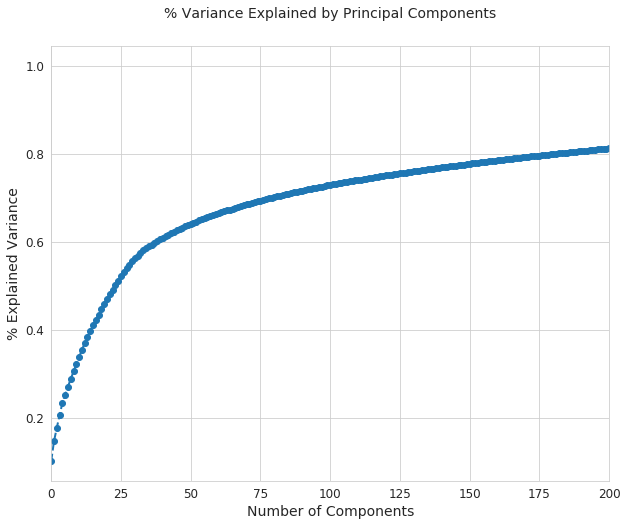

In [60]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [61]:
pca=PCA(n_components=175,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 175 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 175 components is: 0.7944958667037355


In [62]:
X_train=X_pca_21[:31346]
Y_train=fs.iloc[:31346]['Target'].values
X_test=X_pca_21[31346:]
Y_test=fs.iloc[31346:]['Target'].values

## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [63]:
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC','Precision','Recall'])

feat_imp=[None]*5
j=0
for i in range(0,8):
    if i>=1 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc,prec,rec=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,175).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc,prec,rec=f[i](X_train,Y_train,X_test,Y_test)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc,prec,rec])
    print("\n")

K-Nearest Neighbors


distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/utils.py", line 713, in log_errors
    yield
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 1223, in _close
    quiet_exceptions=(CancelledError,),
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 584, in with_timeout
    chain_future(future_converted, result)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 166, in chain_future
    future_add_done_callback(a, copy)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 262, in future_add_done_callback
    callback(future)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 160, in copy
    elif a.exception() is not None:
concurrent.futures._base.CancelledError
Exception ignored in: <bound method

Accuracy of the model for training data is: 0.9814330377081605
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28074   129    28203
True         453  2690     3143
__all__    28527  2819    31346

Accuracy of the model for test data is: 0.9335204797754243
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6483    56     6539
True         465   833     1298
__all__     6948   889     7837



RandomForest Classifier
Accuracy of the model for training data is: 0.996107956358068
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28192    11    28203
True         111  3032     3143
__all__    28303  3043    31346

Accuracy of the model for test data is: 0.925736889115733
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6505    34     6539
True         548   750     1298
__all__     7053   784     7837



Adaoost Classifier
Accuracy of the model for training data is: 0.9732342244624513
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27885   318    28203
True         521  2622     3143
__all__    28406  2940    31346

Accuracy of the model for test data is: 0.9423248692101569
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6442    97     6539
True         355   943     1298
__all__     6797  1040     7837



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9793913098959995
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28060   143    28203
True         503  2640     3143
__all__    28563  2783    31346

Accuracy of the model for test data is: 0.9555952532856961
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6494    45     6539
True         303   995     1298
__all__     6797  1040     7837



ExtraTree Classifier
Accuracy of the model for training data is: 0.9991386460792445
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28200     3    28203
True          24  3119     3143
__all__    28224  3122    31346

Accuracy of the model for test data is: 0.9017481179022585
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6503    36     6539
True         734   564     1298
__all__     7237   600     7837



XGB Classifier
Accuracy of the model for training data is: 0.9796465258725197
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28062   141    28203
True         497  2646     3143
__all__    28559  2787    31346

Accuracy of the model for test data is: 0.9504912594104887
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6496    43     6539
True         345   953     1298
__all__     6841   996     7837



Bagging Classifier
Accuracy of the model for training data is: 0.9963950743316532
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28188    15    28203
True          98  3045     3143
__all__    28286  3060    31346

Accuracy of the model for test data is: 0.9452596656884011
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6498    41     6539
True         388   910     1298
__all__     6886   951     7837



Neural Network-1
The accuracy of the model on training data is: 0.9964907803228482


Predicted  False  True  __all__
Actual                         
False      28165    38    28203
True          72  3071     3143
__all__    28237  3109    31346

The accuracy of the model on test data is: 0.9272680872782952


Predicted  False  True  __all__
Actual                         
False       6464    75     6539
True         495   803     1298
__all__     6959   878     7837

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [64]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[0].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'KNN_model')


trace2 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[1].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[2].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[3].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[4].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')


trace1 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[5].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'XGB')


trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[6].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[7].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [65]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.981433,2690.0,28074.0,129.0,453.0,0.004574,0.144130
RandomForestClassifier,0.996108,3032.0,28192.0,11.0,111.0,0.000390,0.035317
AdaBoostClassifier,0.973234,2622.0,27885.0,318.0,521.0,0.011275,0.165765
GradientBoostingClassifier,0.979391,2640.0,28060.0,143.0,503.0,0.005070,0.160038
ExtraTreeClassifier,0.999139,3119.0,28200.0,3.0,24.0,0.000106,0.007636
XGB,0.979647,2646.0,28062.0,141.0,497.0,0.004999,0.158129
BaggingClassifier,0.996395,3045.0,28188.0,15.0,98.0,0.000532,0.031180
Neural Network-1,0.996491,3071.0,28165.0,38.0,72.0,0.001347,0.022908


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC,Precision,Recall
index,,,,,,,,,,,
KNeighborsClassifier,0.933520,833.0,6483.0,56.0,465.0,0.008564,0.358243,0.816596,0.742246,0.937008,0.641757
RandomForestClassifier,0.925737,750.0,6505.0,34.0,548.0,0.005200,0.422188,0.786306,0.709429,0.956633,0.577812
AdaBoostClassifier,0.942325,943.0,6442.0,97.0,355.0,0.014834,0.273498,0.855834,0.779822,0.906731,0.726502
GradientBoostingClassifier,0.955595,995.0,6494.0,45.0,303.0,0.006882,0.233436,0.879841,0.832434,0.956731,0.766564
ExtraTreeClassifier,0.901748,564.0,6503.0,36.0,734.0,0.005505,0.565485,0.714505,0.599798,0.940000,0.434515
XGB,0.950491,953.0,6496.0,43.0,345.0,0.006576,0.265794,0.863815,0.812109,0.956827,0.734206
BaggingClassifier,0.945260,910.0,6498.0,41.0,388.0,0.006270,0.298921,0.847404,0.791014,0.956887,0.701079
Neural Network-1,0.927268,803.0,6464.0,75.0,495.0,0.011470,0.381356,0.847404,0.715626,0.914579,0.618644


In [66]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')